In [1]:
import glob
import sys
import os
import cv2
import numpy as np
print(cv2.__version__)
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import time
from keras.models import Sequential
from keras.layers import InputLayer, Input , Conv2D, Dense, Flatten , Reshape , MaxPool2D , Dropout , BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras

3.4.1


C:\Users\NafiS\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from data_utils import load_tl_extracts
from random_mini_batch import random_mini_batches

In [3]:
desired_dim = (64,64)
data_dirs = ['data']
test_data = ['test']
gen_data = ['data_gen']

In [4]:
x_train, y_train = load_tl_extracts(data_dirs, desired_dim)
x_test,y_test = load_tl_extracts(test_data, desired_dim)
x_y , y_y = load_tl_extracts(gen_data, desired_dim)
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.shape)
print('x test shape: ',x_test.shape)
print('y test shape: ',y_test.shape)
print('x yell shape: ',x_y.shape)
print('y yell shape: ',y_y.shape)

x train shape:  (12503, 64, 64, 3)
y train shape:  (12503,)
x test shape:  (13332, 64, 64, 3)
y test shape:  (13332,)
x yell shape:  (1600, 64, 64, 3)
y yell shape:  (1600,)


In [7]:
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)
np.save('x_y.npy', x_y)
np.save('y_y.npy', y_y)

In [5]:
#keep only green,red,yellow,off,background
relevant = ['green','off','yellow','red','background']
x_train = x_train[np.isin(y_train, relevant)]
y_train = y_train[np.isin(y_train, relevant)]

In [6]:
print('After keeping Only 5 Classes: ')
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.reshape((11189,1)).shape)
print('x test shape: ',x_test.shape)
print('y test shape: ',y_test.reshape((13332,1)).shape)

After keeping Only 5 Classes: 
x train shape:  (11189, 64, 64, 3)
y train shape:  (11189, 1)
x test shape:  (13332, 64, 64, 3)
y test shape:  (13332, 1)


In [7]:
x_train = x_train.reshape(-1, 64, 64, 3)
x_test = x_test.reshape(-1, 64, 64, 3)
x_y = x_y.reshape(-1, 64, 64, 3)
print('x train shape: ',x_train.shape)
print('x test shape: ',x_test.shape)
print('x y shape: ',x_y.shape)

x train shape:  (11189, 64, 64, 3)
x test shape:  (13332, 64, 64, 3)
x y shape:  (1600, 64, 64, 3)


In [8]:
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.
x_y = x_y.astype("float32")/255.

In [9]:
from numpy import array
values_train = array(y_train)
values_test = array(y_test)
values_y = array(y_y)
print(values_train.shape)
print(values_test.shape)
print(values_y.shape)


(11189,)
(13332,)
(1600,)


In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(values_train)
y_y = label_encoder.fit_transform(values_y)
print(y_train[0:10])
y_y[:] = 4 
print(y_y[0:10])

[4 4 4 3 3 3 3 3 3 3]
[4 4 4 4 4 4 4 4 4 4]


In [11]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_y = to_categorical(y_y)

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.33, random_state=42)

In [13]:
x_train = np.row_stack((x_train,x_y))
y_train = np.row_stack((y_train,y_y))

In [15]:
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.shape)
print('x validation shape: ',x_validation.shape)
print('y validation shape: ',y_validation.shape)
y_train[-1]

x train shape:  (9096, 64, 64, 3)
y train shape:  (9096, 5)
x validation shape:  (3693, 64, 64, 3)
y validation shape:  (3693, 5)


array([0., 0., 0., 0., 1.])

In [16]:
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_validation.npy', x_validation)
np.save('y_validation.npy', y_validation)

In [15]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (7, 7) ,
                 activation='relu',input_shape = (64, 64, 3), name='layer_conv1'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3) ,
                 activation='relu', name='layer_conv2'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3, 3) ,
                 activation='relu', name='layer_conv3'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 58, 58, 32)        4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 58, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 27, 27, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 27, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 11, 11, 128)       73856     
__________

In [17]:
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=10, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_tl.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [19]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer = Adam(lr=1e-5), metrics=["accuracy"])

In [20]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [21]:
hist = model.fit(x=x_train,y=y_train,
           epochs=100, batch_size=64,
           validation_data=(x_validation, y_validation), #For speed
           callbacks=[annealer,early_stop,checkpoint])

Train on 9096 samples, validate on 3693 samples
Epoch 1/100
9096/9096 [==============================] - 8s 905us/step - loss: 0.5956 - acc: 0.8243 - val_loss: 0.3626 - val_acc: 0.8822

Epoch 00001: val_loss improved from inf to 0.36261, saving model to weights_tl.h5
Epoch 2/100
9096/9096 [==============================] - 6s 680us/step - loss: 0.3236 - acc: 0.8981 - val_loss: 0.4844 - val_acc: 0.8597

Epoch 00002: val_loss did not improve from 0.36261
Epoch 3/100
9096/9096 [==============================] - 6s 677us/step - loss: 0.2451 - acc: 0.9228 - val_loss: 0.2639 - val_acc: 0.9215

Epoch 00003: val_loss improved from 0.36261 to 0.26394, saving model to weights_tl.h5
Epoch 4/100
9096/9096 [==============================] - 6s 682us/step - loss: 0.2365 - acc: 0.9232 - val_loss: 0.5054 - val_acc: 0.8478

Epoch 00004: val_loss did not improve from 0.26394
Epoch 5/100
9096/9096 [==============================] - 6s 680us/step - loss: 0.2114 - acc: 0.9347 - val_loss: 0.3360 - val_acc: 

In [22]:
model.load_weights("weights_tl.h5")

In [23]:
final_loss, final_acc = model.evaluate(x_validation, y_validation, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.1343, final accuracy: 0.9610


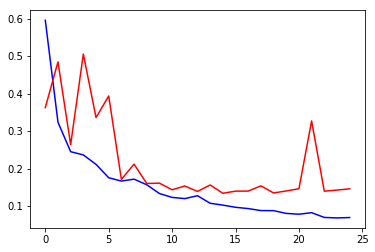

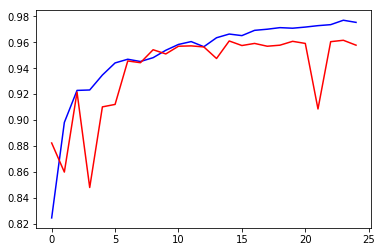

In [24]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [25]:
y_train_pred = model.predict(x=x_train)
y_train_pred = np.argmax(y_train_pred,axis=1)
y_val_pred = model.predict(x=x_validation)
y_val_pred = np.argmax(y_val_pred,axis=1)

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
target_names = ['class 0', 'class 1', 'class 2', 'class 3','class 4']
y_tain_true_class = np.argmax(y_train,axis=1)
y_validation_true_class = np.argmax(y_validation,axis=1)
print("train accuricy: %f" % accuracy_score(y_tain_true_class, y_train_pred))
print("validation accuricy: %f" % accuracy_score(y_validation_true_class, y_val_pred))

train accuricy: 0.973725
validation accuricy: 0.961007


In [27]:
print(classification_report(y_validation_true_class, y_val_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.99      1.00      0.99       598
    class 1       0.98      0.99      0.99      1705
    class 2       0.85      0.85      0.85       240
    class 3       0.94      0.97      0.95      1011
    class 4       0.83      0.63      0.71       139

avg / total       0.96      0.96      0.96      3693



In [28]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

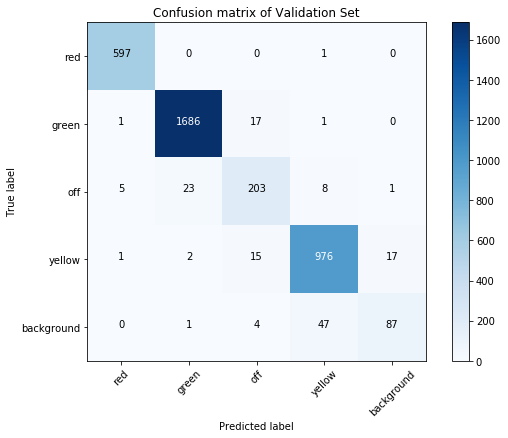

In [29]:
cnf_matrix = confusion_matrix(y_validation_true_class,y_val_pred)
class_names =  ['red','green','off','yellow','background']
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix of Validation Set')